In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import easygdf as eg
import math
import pandas as pd
import copy
from sklearn.metrics import mean_squared_error
from time import process_time

In [3]:
path_to_folder="C:\\Users\\anura\\Desktop\\VECC\\GPT Input Files\\New folder"
os.chdir(path_to_folder)

sim_prof_file_name="sol100.gdf"
gpt_input_file_name="sol100.in"
meas_prof_file_name="sol100_coupled.gdf"
mr_file_name="Bfac.mr"
input_dist_file_name="particle.gdf"

Bfac_list=[0.2, 0.28, 0.4, 0.45, 0.6, 0.65, 0.78]
hist2d_bound_x=[-0.04, 0.04]
hist2d_bound_y=[-0.04, 0.04]
bin_width=0.0003  
num_iter=2
num_initial_particles=len(eg.load_initial_distribution(path_to_folder + "\\" + input_dist_file_name)['ID'])

In [4]:
def binary_search(array, x, low, high):

    while low <= high:

        mid = low + (high - low)//2

        if array[mid] == x:
            return mid

        elif array[mid] < x:
            low = mid + 1

        else:
            high = mid - 1

    return -1

In [5]:
def binary_search_interval(array, x, low, high):
    
    while low <= high:

        mid = low + (high - low)//2
        
        if mid==len(array)-1:
            return -1
            
        if x>=array[mid] and x<=array[mid+1]:
            return mid

        elif array[mid] < x and array[mid+1] < x:
            low = mid + 1

        else:
            high = mid - 1

    return -1

In [6]:
# Change the license number to the license number installed in your system for running GPT
def run_gpt(inname, outname, Bfac, path_to_folder=path_to_folder, License = 1451033234):  
    """
    Accessing a GPT input file from path to the folder given, runs GPT from gpt_path, generates a .gdf file in path_to_folder location
    :param inname: str, the GPT input file name as a string, Ex-"test.in"
    :param outname: str, the desired GPT output file as a string, Ex-"test.gdf"
    :param path_to_folder: str, the path to the project folder, Ex-"C:\\test\\Project"
    :param Bfac: float, value of Bfac desired in simulation, Ex-0.29
    :param License: int, License number of GPT code installed in the system, Ex-1451033234
    """
    
    if os.path.exists(path_to_folder):
        os.chdir(path_to_folder)
    else:
        print("Can't change the Current Working Directory to path_to_folder")
        
    os.system(".\\GPT\\gpt.exe" + " -o " + ".\\Simulated\\" + outname + inname + " Bfac=" + str(Bfac) + " GPTLICENSE=" + str(License)) 
    

In [7]:
# Change the license number to the license number installed in your system for running GPT
def run_mr(inname, outname, mr_name, path_to_folder=path_to_folder, License = 1451033234):
    """
    Accessing a GPT input file from path to the folder given, runs GPT from gpt_path, generates a .gdf file in path_to_folder location
    :param inname: str, the GPT input file name as a string, Ex-"test.in"
    :param outname: str, the desired GPT output file as a string, Ex-"test.gdf"
    :param path_to_folder: str, the path to the project folder, Ex-"C:\\test\\Project"
    :param gpt_path: str, the path to the gpt application, Ex-'"C:\\test\\gpt.exe"'
    :param Bfac: float, value of Bfac desired in simulation, Ex-0.29
    :param License: int, License number of GPT code installed in the system, Ex-1451033234
    """
    
    if os.path.exists(path_to_folder):
        os.chdir(path_to_folder)
    else:
        print("Can't change the Current Working Directory to path_to_folder")
        
    os.system(".\\GPT\\mr.exe" + " -o " + ".\\Simulated\\" + outname + " " + mr_name + " .\\GPT\\gpt.exe " + inname + " GPTLICENSE=" + str(License)) 
    

In [8]:
def asci2gdf(inname, outname, path_to_folder=path_to_folder):
    
    if os.path.exists(path_to_folder):
        os.chdir(path_to_folder)
    else:
        print("Can't change the Current Working Directory to path_to_folder")
        
    os.system(".\\GPT\\asci2gdf.exe" + " -o " + outname + " " + inname)


In [9]:
def gdf2a(inname, outname, path_to_folder=path_to_folder):
    
    if os.path.exists(path_to_folder):
        os.chdir(path_to_folder)
    else:
        print("Can't change the Current Working Directory to path_to_folder")
        
    os.system(".\\GPT\\gdf2a.exe" + " -o " + outname + " " + inname)
    

In [10]:
def profile_at_time(inname, time):
    
    profile = eg.load(inname)
    
    for i in range(1, len(profile['blocks'])):
        if math.isclose(float(profile['blocks'][i]['value']), time, rel_tol=1e-8): 
            prof = profile['blocks'][i]
            
    try: 
        return prof
    except:
        print('Profile not found at the desired time')

In [11]:
def profile_at_Bfac(inname, Bfac):
    
    profile = eg.load(inname)
    
    for i in range(1, len(profile['blocks'])):
        if math.isclose(float(profile['blocks'][i]['value']), Bfac, rel_tol=1e-8):
            if profile['blocks'][i]['children'][1]['name'] != 'time':
                prof = profile['blocks'][i]['children'][2]
            
            else:
                prof = profile['blocks'][i]['children'][1]
            
    try: 
        return prof
    except:
        print('Profile not found at the desired Bfac')

In [12]:
def time_profile_to_df(inname, time):
    
    profile = profile_at_time(inname, time)
    df = pd.DataFrame()

    for i in range(len(profile['children'])):
        df = pd.concat([df, pd.DataFrame(data = profile['children'][i]['value'], columns = [profile['children'][i]['name']])], axis = 1)

    return df

In [13]:
def Bfac_profile_to_df(inname, Bfac):
    
    profile = profile_at_Bfac(inname, Bfac)
    df = pd.DataFrame()

    for i in range(len(profile['children'])):
        df = pd.concat([df, pd.DataFrame(data = profile['children'][i]['value'], columns = [profile['children'][i]['name']])], axis = 1)

    return df

In [14]:
def init_dist_to_df(inname):
    
    profile = eg.load_initial_distribution(inname)
    df = pd.DataFrame()
    
    for i in profile:
        if str(i) == 'creation_time' or str(i) == 'creator' or str(i) == 'destination' or str(i) == 'gdf_version' or str(i) == 'creator_version' or str(i) == 'destination_version' or str(i) == 'dummy':
            continue
        df = pd.concat([df, pd.DataFrame(data = profile[str(i)], columns = [i])], axis = 1)
    
    return df

In [15]:
#infile="sol100.in"
#outfile="sol100.gdf"
#run_gpt(infile, outfile, "C:\\Users\\anura\\Desktop\\VECC\\GPT Input Files", 0.29)
#asci2gdf("4DUniformDist20K.dat", "particle.gdf", "C:\\Users\\anura\\Desktop\\VECC\\GPT Input Files\\New folder")
#run_mr(infile, outfile, "Bfac.mr", "C:\\Users\\anura\\Desktop\\VECC\\GPT Input Files\\New folder")
#gdf2a("sol100.gdf", "rgdsg.txt", "C:\\Users\\anura\\Desktop\\VECC\\GPT Input Files\\New folder")

In [16]:
#os.chdir("C:\\Users\\anura\\Desktop\\VECC\\GPT Input Files\\New folder")
#out_profile = eg.load('.\\Simulated\\sol100.gdf')
#out_profile
#out_profile['blocks'][1]['children']
#Function for calculating error between measured and simulated 2D profiles
#out_profile['blocks'][3]['children']
#hj=profile_at_Bfac(".\\Simulated\\sol100.gdf", 0.2)['children']
#hj
#profile_at_Bfac(".\\Simulated\\sol100.gdf", 0.2)['children']
#Bfac_profile_to_df("measured.gdf", 0.2)
#profile_at_time("sol100.gdf", 0)
#d = time_profile_to_df("sol100.gdf", 2e-11)
#d
#p=init_dist_to_df("C:\\Users\\anura\\Desktop\\VECC\\GPT Input Files\\New folder\\particle.gdf")
#p

In [17]:
def weight_assn(sim_name, meas_name, Bfac, hist2d_bound_x=hist2d_bound_x, hist2d_bound_y=hist2d_bound_y, bin_width=bin_width, path_to_folder=path_to_folder):
    
    sim_prof = profile_at_Bfac(path_to_folder + "\\Simulated\\" + sim_name, Bfac)['children']
    meas_prof = profile_at_Bfac(path_to_folder + "\\Measured\\" + meas_name, Bfac)['children']
    dict_weight={}
    
    sim_hist2d = plt.hist2d(x=sim_prof[0]['value'], y=sim_prof[1]['value'], bins=[np.arange(hist2d_bound_x[0], hist2d_bound_x[1], bin_width),\
                                                                                  np.arange(hist2d_bound_y[0], hist2d_bound_y[1], bin_width)])
    
    plt.colorbar()
    plt.title("Simulated Bfac = " + str(Bfac))
    plt.xlabel("x (in m)")
    plt.ylabel("y (in m)")
    plt.xticks(rotation='vertical')
    plt.show()
    
    meas_hist2d = plt.hist2d(x=meas_prof[0]['value'], y=meas_prof[1]['value'], bins=[np.arange(hist2d_bound_x[0], hist2d_bound_x[1], bin_width),\
                                                                                     np.arange(hist2d_bound_y[0], hist2d_bound_y[1], bin_width)])  
    
    plt.colorbar()
    plt.title("Measured Bfac = " + str(Bfac))
    plt.xlabel("x (in m)")
    plt.ylabel("y (in m)")
    plt.xticks(rotation='vertical')
    plt.show()
    
    for i in range(len(sim_prof[12]['value'])):
        
        j=binary_search_interval(meas_hist2d[1], sim_prof[0]['value'][i], 0, len(meas_hist2d[1])-1)
        k=binary_search_interval(meas_hist2d[2], sim_prof[1]['value'][i], 0, len(meas_hist2d[2])-1)
        
        if j != -1 and k != -1 and meas_hist2d[0][j,k]!=0 and sim_hist2d!=0:
            dict_weight[sim_prof[12]['value'][i]]=meas_hist2d[0][j,k]/sim_hist2d[0][j,k]
            
    return dict_weight

In [18]:
#a=weight_assn("sol100.gdf", "sol100_coupled.gdf", 0.2)
#len(a)

In [1]:
def final_particle_weight(sim_name, meas_name, bin_width=bin_width, path_to_folder=path_to_folder, Bfac_list=Bfac_list):
    
    weight_list=[]
    for i in range(len(Bfac_list)):
        weight_list.append(weight_assn(sim_name, meas_name, Bfac_list[i]))

    arr = np.zeros(9999999)   #Something very high than the Total number of initial particles in initial particle distribution
    dict_final={}
    
    for i in range(len(Bfac_list)):
        for j in weight_list[i].keys():
            arr[int(j)-1]+=1
    
    for j in range(len(arr)):
        if arr[j]==len(Bfac_list):
            for k in range(len(weight_list)-1):
                dict_final[float(j+1)] = weight_list[0][float(j+1)]
                dict_final[float(j+1)] += weight_list[k+1][float(j+1)]
            
    return dict_final

NameError: name 'bin_width' is not defined

In [20]:
def del_particles(dict_meas, inname, outname, path_to_folder=path_to_folder):
    input_prof = eg.load_initial_distribution(path_to_folder + "\\" + inname)
    prof_copy = copy.deepcopy(input_prof)
    
    for i in input_prof.keys():
        if i=='x' or i=='y' or i=='z' or i=='Bx' or i=='By' or i=='Bz' or i=='GBx' or i=='GBy' or i=='GBz' or i=='gamma' or i=='ID':
            input_prof[i]=np.array([])
            
    for i in dict_meas.keys():
        for j in prof_copy.keys():
            index = binary_search(prof_copy['ID'], i, 0, len(prof_copy['ID'])-1)
            if j=='x' or j=='y' or j=='z' or j=='Bx' or j=='By' or j=='Bz' or j=='GBx' or j=='GBy' or j=='GBz' or j=='gamma' or j=='ID':
                input_prof[j] = np.append(input_prof[j], prof_copy[j][index])
    
    if 'Bx' in input_prof.keys() and 'By' in input_prof.keys() and 'Bz' in input_prof.keys():            
        try:             
            eg.save_initial_distribution(path_to_folder + "\\Input\\" + outname, x=input_prof['x'], y=input_prof['y'], z=input_prof['z'],\
                                         Bx=input_prof['Bx'], By=input_prof['By'], Bz=input_prof['Bz'], gamma=input_prof['gamma'], ID=input_prof['ID'])

        except:
            print("Can't save file")
            
    if 'GBx' in input_prof.keys() and 'GBy' in input_prof.keys() and 'GBz' in input_prof.keys():   
        try:             
            eg.save_initial_distribution(path_to_folder + "\\Input\\" + outname, x=input_prof['x'], y=input_prof['y'], z=input_prof['z'],\
                                         GBx=input_prof['GBx'], GBy=input_prof['GBy'], GBz=input_prof['GBz'], gamma=input_prof['gamma'], ID=input_prof['ID'])

        except:
            print("Can't save file")
        
    return input_prof

In [21]:
#fg=del_particles(bcd, "particle.gdf", "particle1.gdf")
#fg

In [22]:
def input_file_place(new_name, prev_name, path_to_folder=path_to_folder):
    
    if os.path.exists(path_to_folder):
        os.chdir(path_to_folder)
    else:
        print("Can't change the Current Working Directory to path_to_folder")
        
    os.system("copy " + ".\\Input\\" + new_name + " " + ".\\")
    os.system("del " + ".\\" + prev_name)
    os.system("rename " + ".\\" + new_name + " particle.gdf")

In [23]:
#input_file_place("particle1.gdf", "particle.gdf")

In [24]:
#sum=0
#for i in bcd.values():
#    sum+=i
    
#sum

In [25]:
#len(bcd)

In [26]:
def final_weight_scaling(final_weight_dict, init_particles=num_initial_particles):
    weight_sum = 0
    for i in final_weight_dict.values():
        weight_sum += i
    
    for j in final_weight_dict.keys():
        final_weight_dict[j] = (final_weight_dict[j]*init_particles)/weight_sum
        
    return final_weight_dict

In [27]:
#fin=final_weight_scaling(bcd, 30000)

In [28]:
#sum=0
#for i in fin.values():
#    if i<=0.5:
#        sum=sum
#    if i>=0.5 and i<=1.5:
#        sum+=1
#    if i>=1.5:
#        if i%1 < 0.5:
#            sum+=math.floor(i)
#        if i%1 >= 0.5:
#            sum+=math.ceil(i)
    
    
#sum

In [29]:
def new_particle_generation(final_weight_dict, inname, outname, bin_width=bin_width, path_to_folder=path_to_folder):
    input_prof = eg.load_initial_distribution(path_to_folder + "\\" + inname)
    prof_copy = copy.deepcopy(input_prof)
    alt_weight_dict = {}
            
    for i in final_weight_dict.keys():
        index = np.where(prof_copy['ID']==i)
        
        for j in range(len(prof_copy['x'])):
            if abs(prof_copy['x'][index]-prof_copy['x'][j])<=bin_width and abs(prof_copy['y'][index]-prof_copy['y'][j])<=bin_width:
                final_weight_dict[i]-=1
    
    '''for i in final_weight_dict.keys():
        if final_weight_dict[i]<=0.5:
            number=0
        if final_weight_dict[i]>=0.5 and final_weight_dict[i]<=1.75:
            number=1
        if final_weight_dict[i]>=1.75:
            if final_weight_dict[i]%1 < 0.5:
                number=math.floor(final_weight_dict[i])
            if final_weight_dict[i]%1 >= 0.5:
                number=math.ceil(final_weight_dict[i])'''
    
    for i in final_weight_dict.keys():
        if final_weight_dict[i]<2:
            number=0
        if final_weight_dict[i]>=2 and final_weight_dict[i]<=3:
            number=1
        if final_weight_dict[i]>=3:
            if final_weight_dict[i]%1 < 0.5:
                number=math.floor(final_weight_dict[i]+0.75)
            if final_weight_dict[i]%1 >= 0.5:
                number=math.ceil(final_weight_dict[i]+0.75)
        
        index = np.where(prof_copy['ID']==i)
        
        if number!=0 or number!=1:
            for j in prof_copy.keys():
                if j=='ID':
                    flag=number
                    while flag!=0:
                        new = np.random.randint(low=30000, high=9999999)
                        if not new in input_prof[j]:
                            input_prof[j] = np.append(input_prof[j], new)
                            flag-=1
                    input_prof[j] = np.sort(input_prof[j], axis=None)
                if j=='z':
                    input_prof[j] = np.append(input_prof[j], np.zeros(number))
                if j=='x' or j=='y':
                    input_prof[j] = np.append(input_prof[j], np.random.uniform(prof_copy[j][index]-bin_width/2, prof_copy[j][index]+bin_width/2, number))
                if j=='gamma':
                    input_prof[j] = np.append(input_prof[j], np.zeros(number) + prof_copy[j][index])
                if j=='Bz' or j=='GBz':
                    input_prof[j] = np.append(input_prof[j], np.zeros(number) + prof_copy[j][index])
                if j=='Bx' or j=='By' or j=='GBx' or j=='GBy':
                    input_prof[j] = np.append(input_prof[j], np.random.uniform(prof_copy[j][index]-bin_width*prof_copy['Bz'][index]/2, prof_copy[j][index]+bin_width*prof_copy['Bz'][index]/2, number))

    if 'Bx' in input_prof.keys() and 'By' in input_prof.keys() and 'Bz' in input_prof.keys():            
        try:             
            eg.save_initial_distribution(path_to_folder + "\\Input\\" + outname, x=input_prof['x'], y=input_prof['y'], z=input_prof['z'],\
                                         Bx=input_prof['Bx'], By=input_prof['By'], Bz=input_prof['Bz'], gamma=input_prof['gamma'], ID=input_prof['ID'])

        except:
            print("Can't save file")
            
    if 'GBx' in input_prof.keys() and 'GBy' in input_prof.keys() and 'GBz' in input_prof.keys():   
        try:             
            eg.save_initial_distribution(path_to_folder + "\\Input\\" + outname, x=input_prof['x'], y=input_prof['y'], z=input_prof['z'],\
                                         GBx=input_prof['GBx'], GBy=input_prof['GBy'], GBz=input_prof['GBz'], gamma=input_prof['gamma'], ID=input_prof['ID'])

        except:
            print("Can't save file")
    
    return input_prof

In [30]:
#n=new_particle_generation(fin, "particle.gdf", "p.gdf", 0.0005, "C:\\Users\\anura\\Desktop\\VECC\\GPT Input Files\\New folder")

In [31]:
#len(n['ID'])

In [32]:
def RMSE(sim_name, meas_name, Bfac, hist2d_bound_x=hist2d_bound_x, hist2d_bound_y=hist2d_bound_y, bin_width=bin_width, path_to_folder=path_to_folder):
    sim_prof = profile_at_Bfac(path_to_folder + "\\Simulated\\" + sim_name, Bfac)['children']
    meas_prof = profile_at_Bfac(path_to_folder + "\\Measured\\" + meas_name, Bfac)['children']
    
    sim_hist2d = plt.hist2d(x=sim_prof[0]['value'], y=sim_prof[1]['value'], bins=[np.arange(hist2d_bound_x[0], hist2d_bound_x[1], bin_width),\
                                                                                  np.arange(hist2d_bound_y[0], hist2d_bound_y[1], bin_width)])

    meas_hist2d = plt.hist2d(x=meas_prof[0]['value'], y=meas_prof[1]['value'], bins=[np.arange(hist2d_bound_x[0], hist2d_bound_x[1], bin_width),\
                                                                                     np.arange(hist2d_bound_y[0], hist2d_bound_y[1], bin_width)])

    rmse = mean_squared_error(meas_hist2d[0]/len(meas_prof[0]['value']), sim_hist2d[0]/len(sim_prof[0]['value']), squared=False)
    
    return rmse

In [33]:
#rm=RMSE("sol100.gdf", "sol100_coupled.gdf", 0.0005, 0.78)
#rm

In [34]:
def profile_analysis(inname, outname, gdf_type, path_to_folder=path_to_folder, License = 1451033234):
    
    # Change the current working Directory to path_to_folder
    if os.path.exists(path_to_folder):
        os.chdir(path_to_folder)
    else:
        print("Can't change the Current Working Directory to path_to_folder")
    
    if gdf_type=="simulated":
        
        os.system(".\\GPT\\gdfa.exe" + " -o " + ".\\Simulated\\" + outname + " " + ".\\Simulated\\" + inname + " Bfac " + "CSalphax CSbetax CSgammax\
        CSalphay CSbetay CSgammay CSalphaz CSbetaz CSgammaz nemixrms nemiyrms " + "GPTLICENSE=" + str(License))
        file = eg.load(".\\Simulated\\" + outname)
        
    if gdf_type=="measured":
        
        os.system(".\\GPT\\gdfa.exe" + " -o " + ".\\Measured\\" + outname + " " + ".\\Measured\\" + inname + " Bfac " + "CSalphax CSbetax CSgammax\
        CSalphay CSbetay CSgammay CSalphaz CSbetaz CSgammaz nemixrms nemiyrms " + "GPTLICENSE=" + str(License))
        file = eg.load(".\\Measured\\" + outname)
        
    return file['blocks'][0]['children']

In [35]:
rmse_list=[]
for i in range(len(Bfac_list)):
    rmse_list.append(np.array([]))

start_time=process_time()

i=1
while i<=num_iter:     
    run_mr(gpt_input_file_name, sim_prof_file_name, mr_file_name)
    weight=final_particle_weight(sim_prof_file_name, meas_prof_file_name)
    deleted=del_particles(weight, input_dist_file_name, "del_particle" + str(i) + ".gdf")
    input_file_place("del_particle" + str(i) + ".gdf", input_dist_file_name)
    final_weight=final_weight_scaling(weight)
    new_particles=new_particle_generation(final_weight, input_dist_file_name, "new_particle" + str(i) + ".gdf")
    input_file_place("new_particle" + str(i) + ".gdf", input_dist_file_name)
    
    for j in range(len(Bfac_list)):
        rmse=RMSE(sim_prof_file_name, meas_prof_file_name, Bfac_list[j])
        rmse_list[j]=np.append(rmse_list[j], rmse)
    
    profile_analysis(sim_prof_file_name, "simulated_profile_analysis" + str(i) + ".gdf", "simulated")
    profile_analysis(meas_prof_file_name, "measured_profile_analysis" + str(i) + ".gdf", "measured")
    i=i+1
    
stop_time=process_time()

print(stop_time-start_time)

KeyboardInterrupt: 

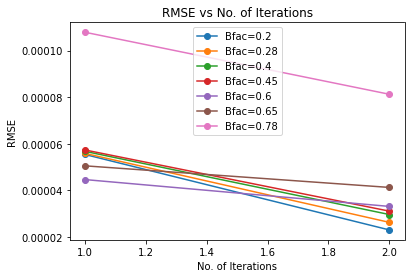

In [39]:
label_list=[]
for k in Bfac_list:
    label_list.append("Bfac=" + str(k))
    
for i in rmse_list:
    plt.plot(np.arange(1,num_iter+1), i, marker="o")
    plt.title("RMSE vs No. of Iterations")
    plt.xlabel("No. of Iterations")
    plt.ylabel("RMSE")
    plt.legend(label_list)

plt.show()

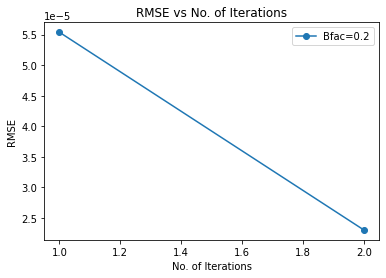

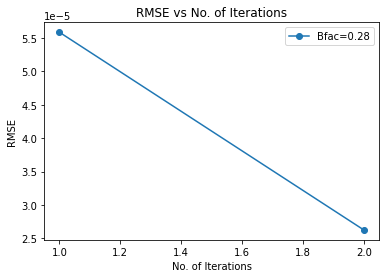

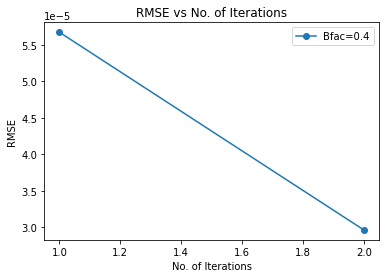

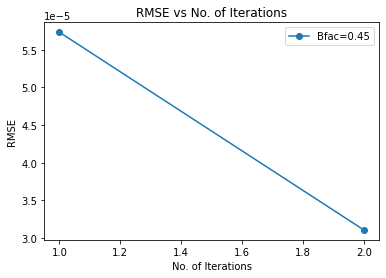

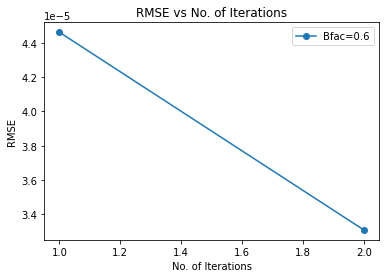

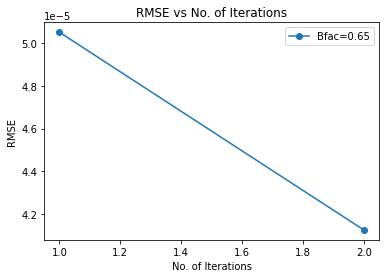

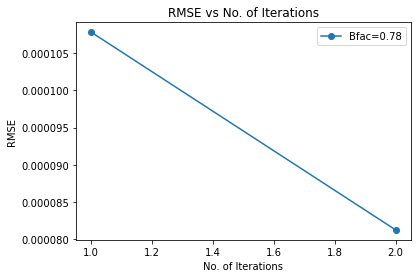

In [40]:
label_list=[]
for k in Bfac_list:
    label_list.append("Bfac=" + str(k))
    
for i, j in zip(rmse_list, Bfac_list):
    plt.plot(np.arange(1,num_iter+1), i, marker="o")
    plt.title("RMSE vs No. of Iterations")
    plt.xlabel("No. of Iterations")
    plt.ylabel("RMSE")
    plt.legend(["Bfac=" + str(j)])
    plt.show()

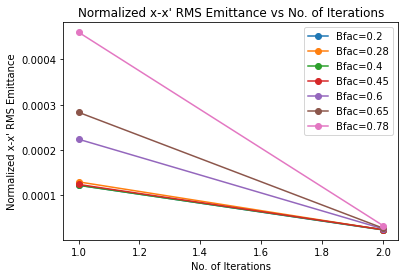

In [41]:
nemixrms_list=[]
for i in range(len(Bfac_list)):
    nemixrms_list.append(np.array([]))

for i in range(1, num_iter+1):
    for j in range(len(Bfac_list)):
        nemixrms=eg.load(path_to_folder + "\\Simulated\\simulated_profile_analysis" + str(i) + ".gdf")['blocks'][0]['children'][10]['value'][j]
        nemixrms_list[j]=np.append(nemixrms_list[j], nemixrms)
        
label_list=[]
for k in Bfac_list:
    label_list.append("Bfac=" + str(k))

for i in range(len(Bfac_list)):
    plt.plot(np.arange(1, num_iter+1), nemixrms_list[i], marker="o")

plt.title("Normalized x-x' RMS Emittance vs No. of Iterations")
plt.xlabel("No. of Iterations")
plt.ylabel("Normalized x-x' RMS Emittance")
plt.legend(label_list)
plt.show()

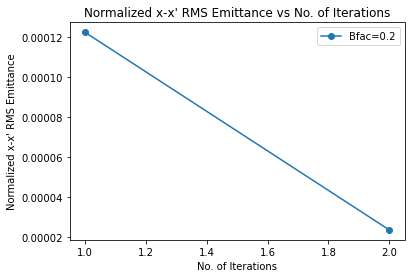

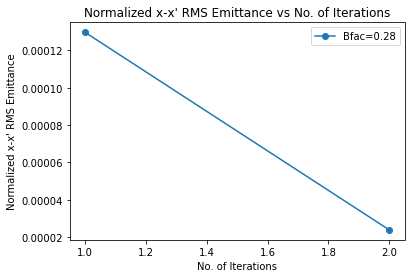

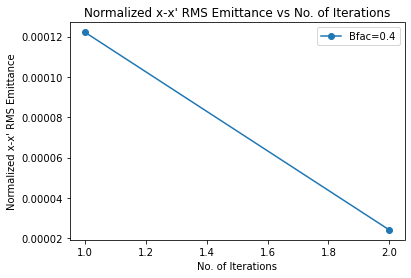

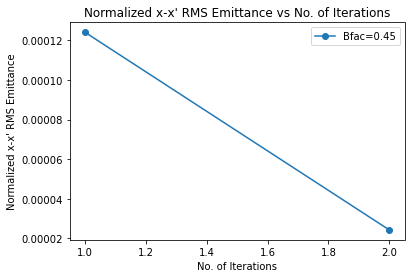

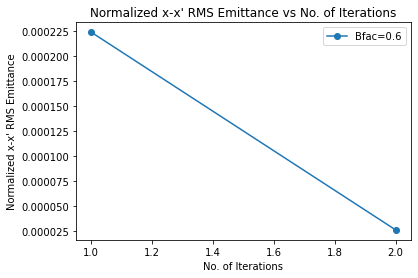

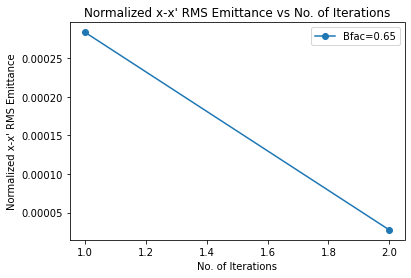

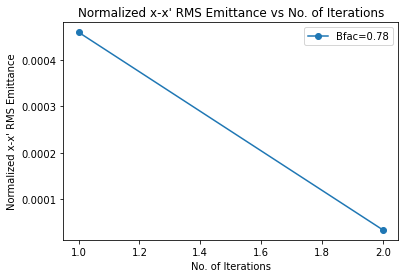

In [42]:
for i, j in zip(nemixrms_list, Bfac_list):
    plt.plot(np.arange(1,num_iter+1), i, marker="o")
    plt.title("Normalized x-x' RMS Emittance vs No. of Iterations")
    plt.xlabel("No. of Iterations")
    plt.ylabel("Normalized x-x' RMS Emittance")
    plt.legend(["Bfac=" + str(j)])
    plt.show()

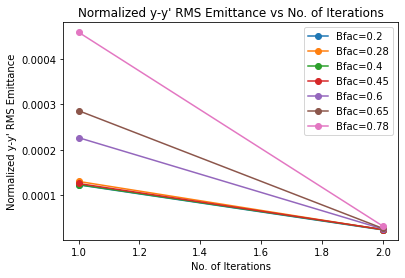

In [43]:
nemiyrms_list=[]
for i in range(len(Bfac_list)):
    nemiyrms_list.append(np.array([]))
    

for i in range(1, num_iter+1):
    for j in range(len(Bfac_list)):
        nemiyrms=eg.load(path_to_folder + "\\Simulated\\simulated_profile_analysis" + str(i) + ".gdf")['blocks'][0]['children'][11]['value'][j]
        nemiyrms_list[j]=np.append(nemiyrms_list[j], nemiyrms)
        
label_list=[]
for k in Bfac_list:
    label_list.append("Bfac=" + str(k))
         
for i in range(len(Bfac_list)):
    plt.plot(np.arange(1, num_iter+1), nemiyrms_list[i], marker="o")
    
plt.title("Normalized y-y' RMS Emittance vs No. of Iterations")
plt.xlabel("No. of Iterations")
plt.ylabel("Normalized y-y' RMS Emittance")
plt.legend(label_list)
plt.show()

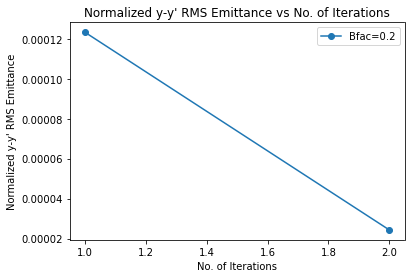

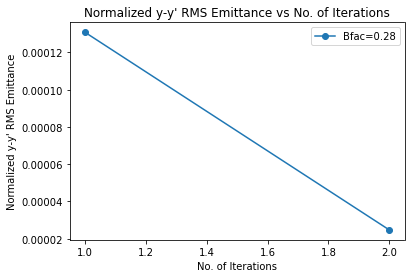

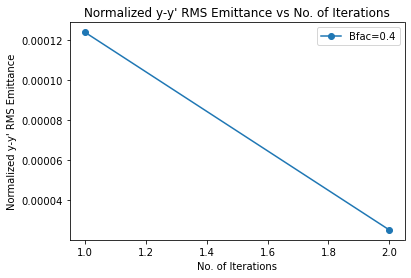

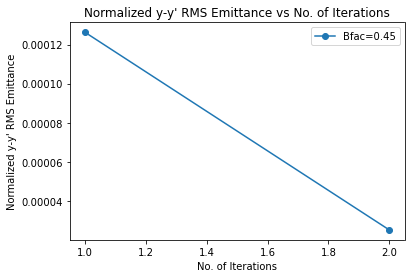

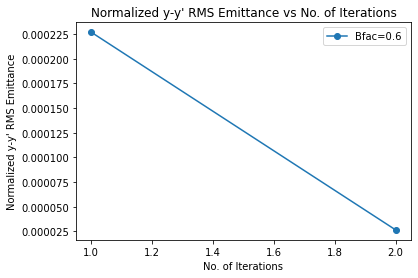

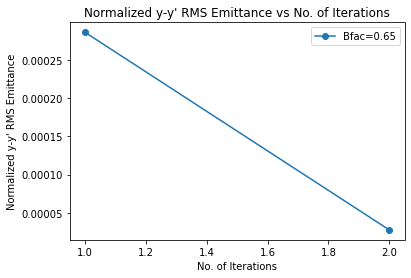

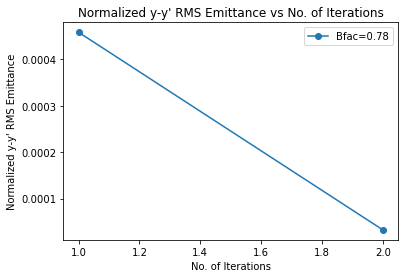

In [44]:
for i, j in zip(nemiyrms_list, Bfac_list):
    plt.plot(np.arange(1,num_iter+1), i, marker="o")
    plt.title("Normalized y-y' RMS Emittance vs No. of Iterations")
    plt.xlabel("No. of Iterations")
    plt.ylabel("Normalized y-y' RMS Emittance")
    plt.legend(["Bfac=" + str(j)])
    plt.show()